# Understanding the relationship between features and target

The strength of multiple linear regression lies in its ability to provide straightforward and interpretable solutions that not only predict future outcomes, but also provide insight into the underlying processes that create these outcomes. One of the reasons why linear regression models are so commonplace is the fact that these models can shed light on the relationships in the data by just interpreting the estimated coefficients. The interpretation of the relationships by looking at the estimated coefficients is called **inference**.

In this checkpoint, we learn to answer questions like:

* How much an increase in an explanatory variable does affect the explained variable?
* How can we single out the effect of a specific variable by isolating the affects of other variables?

The answers to these questions bear a lot of business value. Think about a company that likes to measure the performance of its advertising expenditures. Is radio advertisements are more effective in attracting new customers than the Facebook ads? For a thousand dollars spent on TV ads, how many products does the company sell? And, how can we distinguish whether the new customers are the result of the TV ads or the Google ads?

## Our new medical costs model

We use the medical costs dataset to illustrate how to demonstrate how to interpret the estimated coefficients in a linear regression model. Here, we load the medical costs dataset and build a new regression model including continuous variables as well as the categorical ones. In the dataset, we have two continuous variables: age and bmi (body mass index). In this new model, we add them besides the "is_male" and "is_smoker" dummies as explanatory variables. 

In [5]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(action="ignore")

In [6]:
## todo the data will be loaded from postgre
insurance_df = pd.read_csv("../datasets/insurance.csv")
insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855
5,31,female,25.740,0,no,southeast,3756.622
6,46,female,33.440,1,no,southeast,8240.590
7,37,female,27.740,3,no,northwest,7281.506
8,37,male,29.830,2,no,northeast,6406.411
9,60,female,25.840,0,no,northwest,28923.137


In [7]:
insurance_df["is_male"] = pd.get_dummies(insurance_df.sex)["male"]
insurance_df["is_smoker"] = pd.get_dummies(insurance_df.smoker)["yes"]

insurance_df.region[np.where(np.isin(insurance_df.region, "southwest"))[0]] = 0
insurance_df.region[np.where(np.isin(insurance_df.region, "northwest"))[0]] = 1
insurance_df.region[np.where(np.isin(insurance_df.region, "southeast"))[0]] = 2
insurance_df.region[np.where(np.isin(insurance_df.region, "northeast"))[0]] = 3

In [8]:
# Y is the target variable
Y = insurance_df['charges']
# X is the feature set which includes
# is_male and is_smoker variables
X = insurance_df[['is_male','is_smoker', 'age', 'bmi']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ -109.04110867 23833.87003847   259.45318189   323.0510586 ]

Intercept: 
 -11633.494594179392


Our new model is: 

$$ charges = -11633.50 - 109.04is\_male + 23833.87is\_smoker + 259.45age + 323.05bmi \qquad(eq.1)$$

is_male and is_smoker variables are dummies but age and bmi variables are continuous. Interpreting dummies is slightly different than the continuous variables. In this checkpoint, we'll cover them seperately. But before moving forward, we need to understand how - in a linear regression model, the effects of multiple variables on the target are isolated from each other.

## OLS regression as a controlled experiment

A **controlled experiment** is a scientific experiment type where only the effect of a single factor is measured by controlling other factors that also affect the outcome. For example, if we want to measure the effect of light on the growth of a specific plant, then we need to set up two environments where every factor like humidity, soil etc. are the same but the degree of light.

We can think of the estimated linear regression models as a controlled experiment. When we estimate the coefficients of a model using OLS, we actually get coefficient estimates that are isolated from each other. That is to say, the coefficient of a feature measures the effect of that variable on the outcome variable by holding all other variables constant at their means. So, we can interpret an estimated coefficient as the measure of the relationship between that feature and the target after stripping out the affects of all other features. 

## Interpreting the dummy variables

Consider the coefficients of the dummy variables in (eq.1). The coefficient of is_male is −109.04 and the coefficient of is_smoker is 23833.87. This means that the medical costs of males are 109.04 dollars less than the females on average and the costs of males those who smoke are higher 23833.87 dollars than the female smokers __on average__.

But what does "on average" mean? Linear regression models estimate relationships....

## Interpreting the continuous variables

Now, let's interpret the coefficients of the continuous variables in (eq.1). The coefficient of age is 259.45. We interpret this like: if age of a person increases by one (s/he gets one year older), her/his costs increase by 259.45 dollars on average. We read the coefficient of bmi similarly. If body mass index of a person increases by one point, that person's costs increase by 323.05 dollars on average.

**Note:** Sometimes, transforming the target and features help the interpretation to be more clear. For example, if we take the logarithms of target and a feature and estimate the model after that, we can interpret the "coefficient" of that feature like this: a percantage increase in the value of the original feature (not log transformed) results in the "coefficient" percentage change in the original target (no log transformed). If you wonder why this is the case, you can read this [stackoverflow question](https://stats.stackexchange.com/questions/244199/why-is-it-that-natural-log-changes-are-percentage-changes-what-is-about-logs-th).



## Interpreting the interaction terms

So far, we explained the interpretations of the categorical and continuous variables. But, sometimes we need to use **interactions** in our models to explain the outcome better. Interaction variables are way to capture the non-linear relationships between the target and the features. For example, from (eq.1) we know the difference of average costs between smokers and non-smokers. However, if we believe that the costs of the smokers would increase as the age of a person increases (because the probability of suffering from lung cancer increases) more than the non-smokers, we need to add the interaction of age and the is_smoker dummy to the model.

Mathematically, we capture the interaction of two variables by multiplying them. Now, let's create an interaction variable and add it to our model:

In [11]:
# Y is the target variable
Y = insurance_df['charges']

insurance_df["age_is_smoker"] = insurance_df.age * insurance_df.is_smoker
# X is the feature set which includes
# is_male and is_smoker variables
X = insurance_df[['is_male','is_smoker', 'age', 'bmi', "age_is_smoker"]]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ -113.12393629 22041.5565436    250.10470273   324.08650483
    46.33308368]

Intercept: 
 -11295.056010081527


The estimated model is: 

$$ charges = -11295.05 - 113.12is\_male + 22041.55is\_smoker + 250.10age + 324.08bmi + 46.33age\_is\_smoker \qquad(eq.2)$$

Notice that the coefficient of age is dropped from 259.45 to 250.10 and the coefficient of the interaction variable "age_is_smoker" is 46.33. This means that for a one year increase in age results in 250.10 dollars increase in costs for non-smokers and 296.43 (250.10 + 46.33) dollars increase in costs for smokers.

We can illustrate this in a graph as follows:

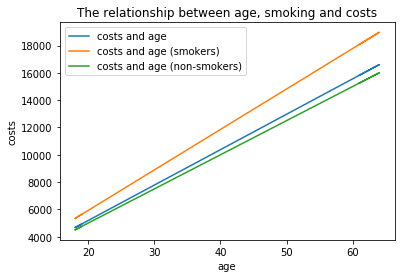

In [23]:

costs_age = insurance_df.age * 259.45
costs_age_smokers = insurance_df.age * (250.10 + 46.33)
costs_age_non_smokers = insurance_df.age * 250.10


plt.plot(insurance_df.age, costs_age)
plt.plot(insurance_df.age, costs_age_smokers)
plt.plot(insurance_df.age, costs_age_non_smokers)
plt.legend(["costs and age", "costs and age (smokers)", "costs and age (non-smokers)"])
plt.xlabel("age")
plt.ylabel("costs")
plt.title("The relationship between age, smoking and costs")

plt.show()

## Interpreting the constant

Constants in linear regression models corresponds to the outcome value that is expected to happen when all the explanatory variables take zero value. In a simple linear regression setting (when there is only a single explanatory variable), constant corresponds to the point the fitted curve crosses the y-axis. 

Although it's easy to visualize the constant term in simple linear regression settings, it gets harder to grasp what a constant term means if there are many features included in the model. For example, if a dummy variable is included in a model, then one category should be excluded from the model as we explained before. In this case, constant term also includes information regarding the hould out category. Hence, a lot of factors may be captured by the constant.

The safest way to think about the constant term is to think of it as the bias. Remember that in the previous checkpoint we said that the constant terms make the residuals zero on average. In this sense, the constant takes the bias from residuals to itself. This is why the constant is also called bias!
